This is a notebook to generate mel-spectrograms from a TTS model to be used for WaveRNN training.

In [7]:
TTS_PATH = "../../"

In [8]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(TTS_PATH)
import torch
import importlib
import numpy as np
import torch.nn as nn
from tqdm import tqdm as tqdm
from torch.utils.data import DataLoader
from synthesizer.models.tacotron2 import Tacotron2
from synthesizer.datasets.TTSDataset import MyDataset
from synthesizer.utils.audio import AudioProcessor
from synthesizer.utils.visual import plot_spectrogram
from synthesizer.utils.generic_utils import load_config, setup_model
from synthesizer.datasets.preprocess import biaobei
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def set_filename(wav_path, out_path):
    wav_file = os.path.basename(wav_path)
    file_name = wav_file.split('.')[0]
    os.makedirs(os.path.join(out_path, "quant"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "mel"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "wav_gl"), exist_ok=True)
    wavq_path = os.path.join(out_path, "quant", file_name)
    mel_path = os.path.join(out_path, "mel", file_name)
    wav_path = os.path.join(out_path, "wav_gl", file_name)
    return file_name, wavq_path, mel_path, wav_path

In [10]:
OUT_PATH = "/search/hadoop07/wuzijun/voice_data/SV2TTS/vocoder/"
DATA_PATH = "/search/hadoop07/wuzijun/voice_data/SV2TTS/synthesizer/"
DATASET = "alldata"
METADATA_FILE = "all.txt"
MODEL_FILE = "../../synthesizer/output/SV2TTS-synthesis-January-15-2020_01+56PM-3a34127/best_model.pth.tar"
CONFIG_PATH = "../../synthesizer/config.json"
VOCODER_CONFIG_PATH = "../config.json"

DRY_RUN = False   # if False, does not generate output files, only computes loss and visuals.
BATCH_SIZE = 10

use_cuda = torch.cuda.is_available()
print(" > CUDA enabled: ", use_cuda)

C = load_config(CONFIG_PATH)
C_vocoder = load_config(VOCODER_CONFIG_PATH)
ap = AudioProcessor(**C.audio)

# enable/disable some TTS options manually
C.prenet_dropout = False
C.separate_stopnet = True
C.use_forward_attn = False
C.forward_attn_mask = False

 > CUDA enabled:  True
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:401
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > sound_norm:False
 | > n_fft:800
 | > hop_length:200
 | > win_length:800


In [5]:
preprocessor = importlib.import_module('synthesizer.datasets.preprocess')
preprocessor = getattr(preprocessor, DATASET.lower())

In [6]:
meta_data = preprocessor(DATA_PATH, METADATA_FILE)

In [7]:
dataset = MyDataset(C.r, C.text_cleaner, ap, meta_data, use_phonemes=C.use_phonemes,  phoneme_cache_path=C.phoneme_cache_path)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, collate_fn=dataset.collate_fn, shuffle=False, drop_last=False)

In [8]:
from synthesizer.utils.text.symbols import symbols, phonemes
from synthesizer.utils.generic_utils import sequence_mask
from synthesizer.layers.losses import L1LossMasked, MSELossMasked
from synthesizer.utils.text.symbols import symbols, phonemes

# load the model
num_chars = len(phonemes) if C.use_phonemes else len(symbols)
model = setup_model(num_chars, 0, C)
checkpoint = torch.load(MODEL_FILE)
model.load_state_dict(checkpoint['model'])
print(checkpoint['step'])
model.eval()
if use_cuda:
    model = model.cuda()

 > Using model: Tacotron2
237696


### Generate model outputs 

In [9]:
import pickle

file_idxs = []
losses_lm = []
losses_mse = []
postnet_losses_lm = []
postnet_losses_mse = []
criterion_lm = L1LossMasked()
criterion_mse = MSELossMasked()
for data in tqdm(loader):
    # setup input data
    text_input = data[0]
    text_lengths = data[1]
    speaker_names = data[2]
    linear_input = data[3] if C.model in ["Tacotron"] else None
    mel_input = data[4]
    mel_lengths = data[5]
    stop_targets = data[6]
    item_idx = data[7]
    speaker_embeddings = data[8]
    wavs = data[9]
    
    # dispatch data to GPU
    if use_cuda:
        text_input = text_input.cuda()
        text_lengths = text_lengths.cuda()
        mel_input = mel_input.cuda()
        mel_lengths = mel_lengths.cuda()
#         linear_input = linear_input.cuda()
        stop_targets = stop_targets.cuda()
        speaker_embeddings = speaker_embeddings.cuda()
    
    mask = sequence_mask(text_lengths)
    mel_outputs, postnet_outputs, alignments, stop_tokens = model.forward(text_input, text_lengths, mel_input, speaker_embeddings)
    
    # compute mel specs from linear spec if model is Tacotron
    mel_specs = []
    if C.model == "Tacotron":
        postnet_outputs = postnet_outputs.data.cpu().numpy()
        for b in range(postnet_outputs.shape[0]):
            postnet_output = postnet_outputs[b]
            mel_specs.append(torch.FloatTensor(ap.out_linear_to_mel(postnet_output.T).T).cuda())
        # change incident here
        postnet_outputs = torch.stack(mel_specs)
    
    loss_lm = criterion_lm(mel_outputs, mel_input, mel_lengths)
    loss_postnet_lm = criterion_lm(postnet_outputs, mel_input, mel_lengths)
    losses_lm.append(loss_lm.item())
    postnet_losses_lm.append(loss_postnet_lm.item())
    
    loss_mse = criterion_mse(mel_outputs, mel_input, mel_lengths)
    loss_postnet_mse = criterion_mse(postnet_outputs, mel_input, mel_lengths)
    losses_mse.append(loss_mse.item())
    postnet_losses_mse.append(loss_postnet_mse.item())
    if not DRY_RUN:
        for idx in range(text_input.shape[0]):
            wav_file_path = item_idx[idx]
            wav = wavs[idx]
            file_name, wavq_path, mel_path, wav_path = set_filename(wav_file_path, OUT_PATH)
            file_idxs.append(file_name)

            # quantize and save wav
            if type(C_vocoder.mode) is int and C_vocoder.mulaw:
                wavq = ap.mulaw_encode(wav, C_vocoder.mode)
                np.save(wavq_path, wavq, allow_pickle=False)
            elif type(C_vocoder.mode) is int:
                wavq = ap.quantize(wav)
                np.save(wavq_path, wavq, allow_pickle=False)

            # save TTS mel
            mel = postnet_outputs[idx]
            mel = mel.data.cpu().numpy()
            mel_length = mel_lengths[idx]
            mel = mel[:mel_length, :].T
            np.save(mel_path, mel)

            # save GL voice
    #         wav_gen = ap.inv_mel_spectrogram(mel.T) # mel to wav
    #         wav_gen = ap.quantize(wav_gen)
    #         np.save(wav_path, wav_gen)

if not DRY_RUN:
    pickle.dump(file_idxs, open(OUT_PATH+"/dataset_ids.pkl", "wb"))      

100%|██████████| 66670/66670 [9:51:55<00:00,  1.88it/s]   


In [10]:
print(f"L1maskloss: mel-{np.mean(losses_lm)}; postnet{np.mean(postnet_losses_lm)}")
print(f"MSEloss: mel-{np.mean(losses_mse)}; postnet{np.mean(postnet_losses_mse)}")

L1maskloss: mel-0.16104247653277154; postnet0.12394438877610121
MSEloss: mel-0.06019022131396827; postnet0.032418589692412514


### Check model performance

In [15]:
postnet_outputs.shape

torch.Size([3, 177, 80])

(177, 80)


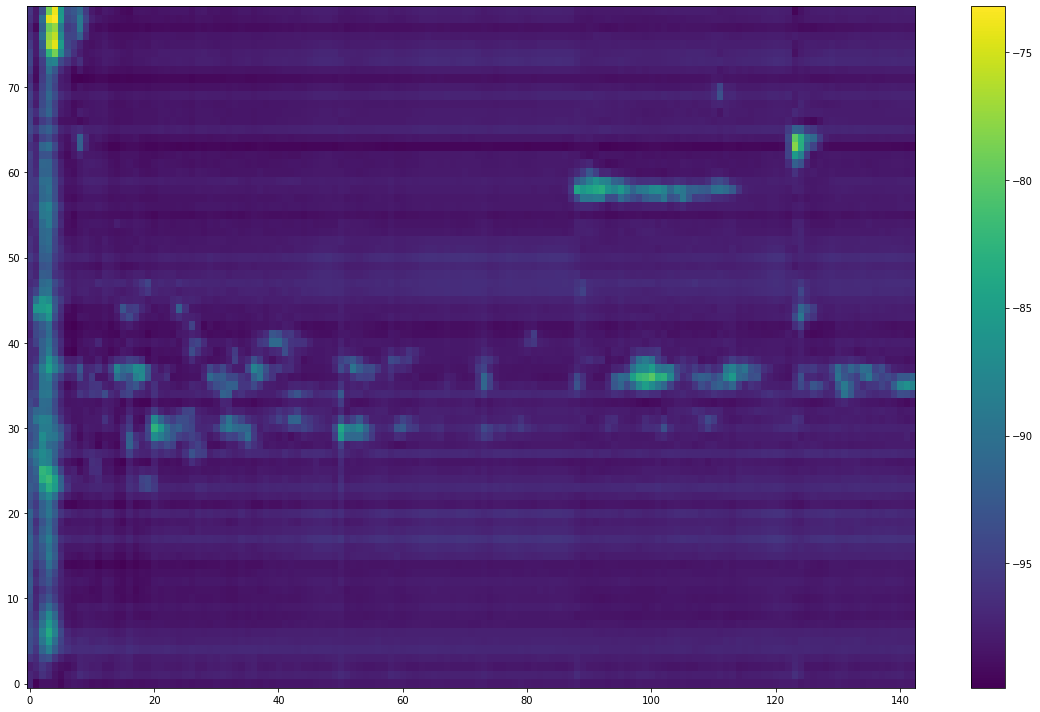

In [21]:
idx = 2
mel_example = postnet_outputs[idx].data.cpu().numpy()
plot_spectrogram(mel_example[:mel_lengths[idx], :], ap);
print(mel_example[:mel_lengths[1], :].shape)

(177, 80)


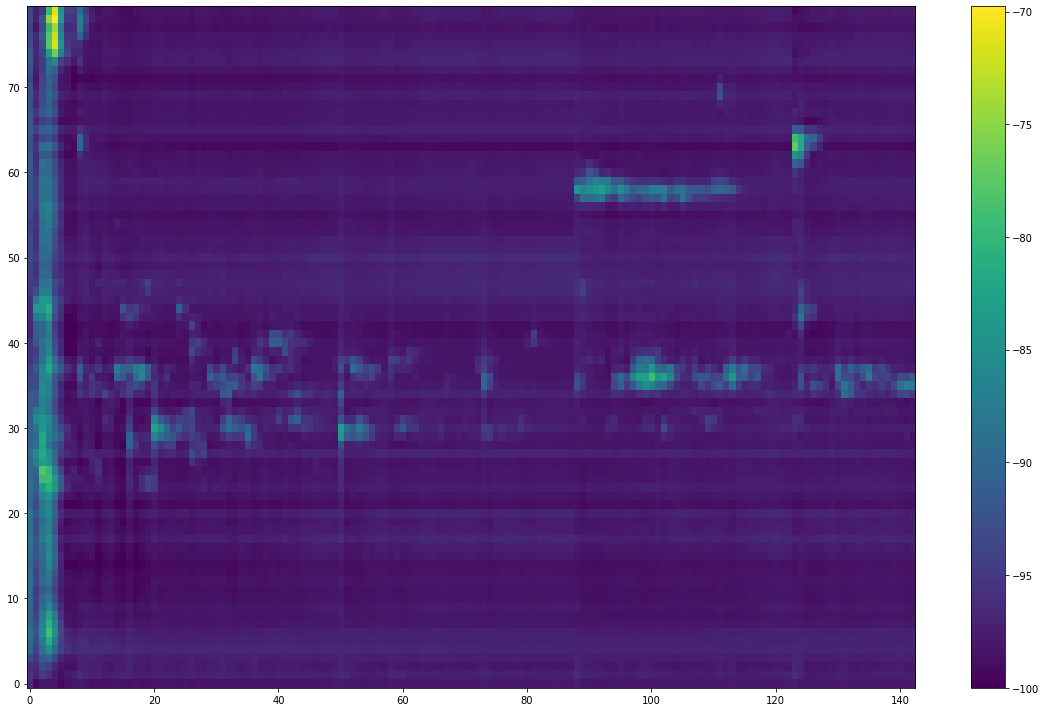

In [22]:
mel_example = mel_outputs[idx].data.cpu().numpy()
plot_spectrogram(mel_example[:mel_lengths[idx], :], ap);
print(mel_example[:mel_lengths[1], :].shape)

In [27]:
item_idx

['/search/hadoop07/wuzijun/voice_data/SV2TTS/synthesizer/audio/audio-14_4041_20170819151342_00.npy',
 '/search/hadoop07/wuzijun/voice_data/SV2TTS/synthesizer/audio/audio-14_4029_20170819135852_00.npy',
 '/search/hadoop07/wuzijun/voice_data/SV2TTS/synthesizer/audio/audio-15_4511_20170824155304_00.npy']

(80, 143)


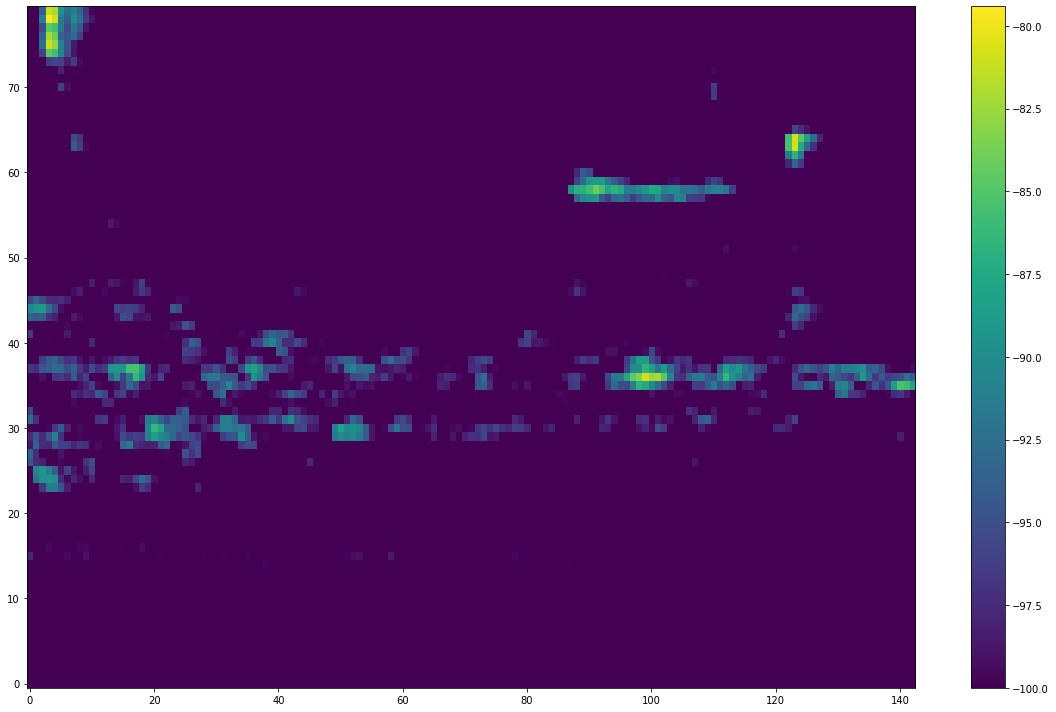

In [28]:
wav = np.load(item_idx[idx])
melt = ap.melspectrogram(wav)
print(melt.shape)
plot_spectrogram(melt.T, ap);

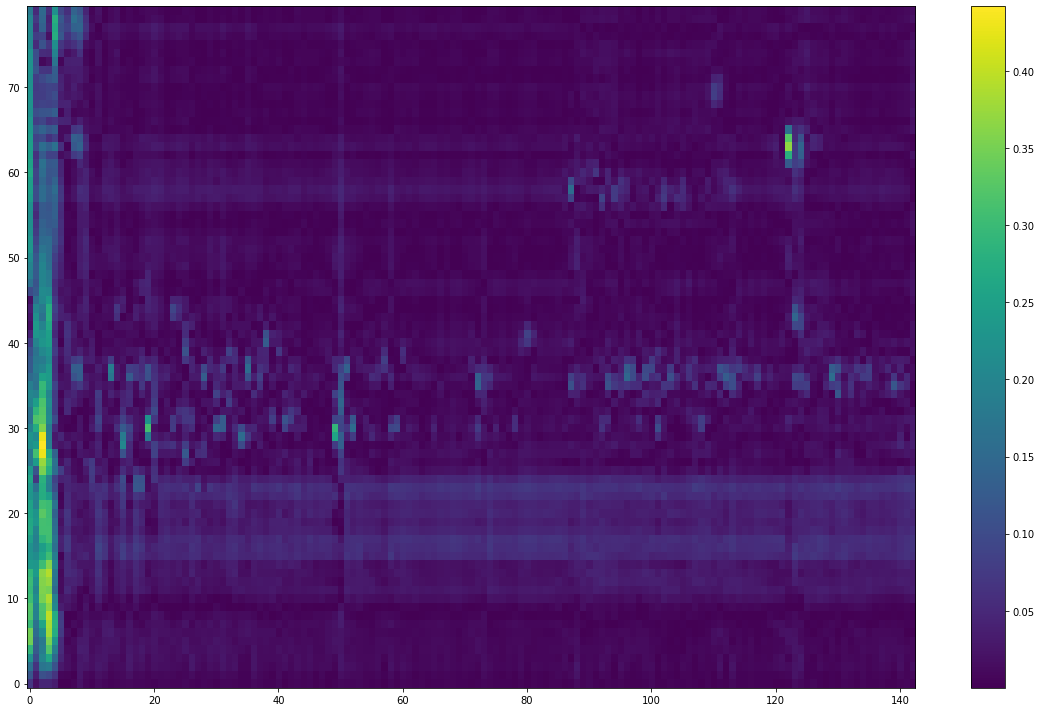

In [29]:
# postnet, decoder diff
from matplotlib import pylab as plt
mel_diff = mel_outputs[idx] - postnet_outputs[idx]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff.detach().cpu().numpy()[:mel_lengths[idx],:]).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

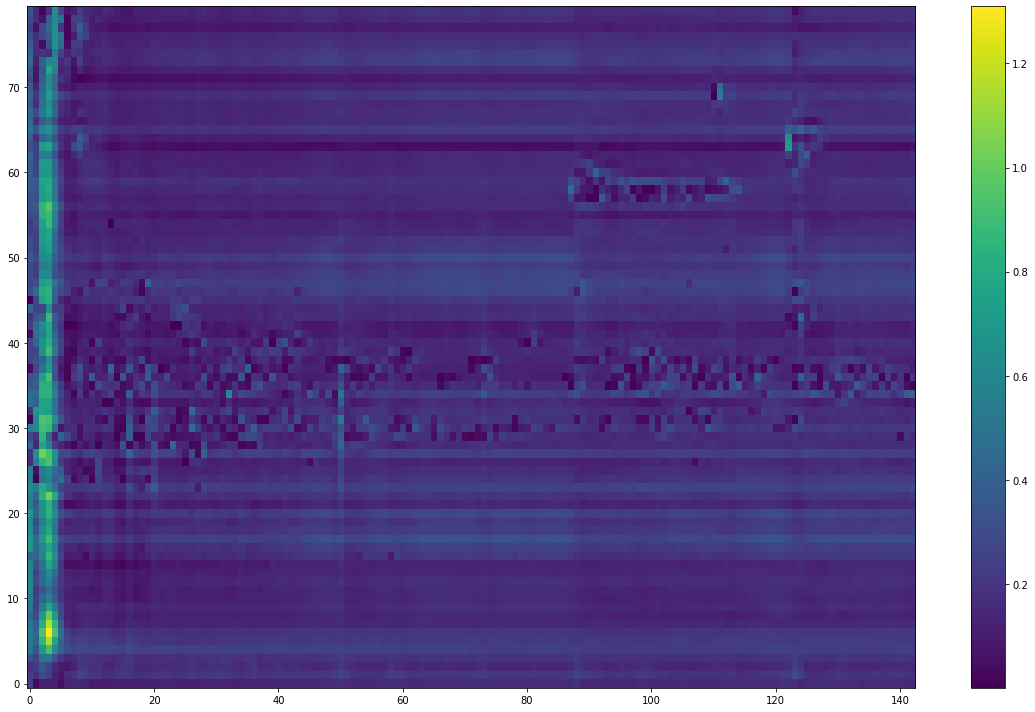

In [30]:
from matplotlib import pylab as plt
# mel = mel_poutputs[idx].detach().cpu().numpy()
mel = postnet_outputs[idx].detach().cpu().numpy()
mel_diff2 = melt.T - mel[:melt.shape[1]]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

In [1]:
import numpy as np

In [3]:
a = np.load('/search/hadoop02/suanfa/wuzijun/Data/voice_data/SV2TTS/vocoder/mel/audio-16_3662_20170812134315_00.npy')

In [5]:
a.shape

(80, 343)

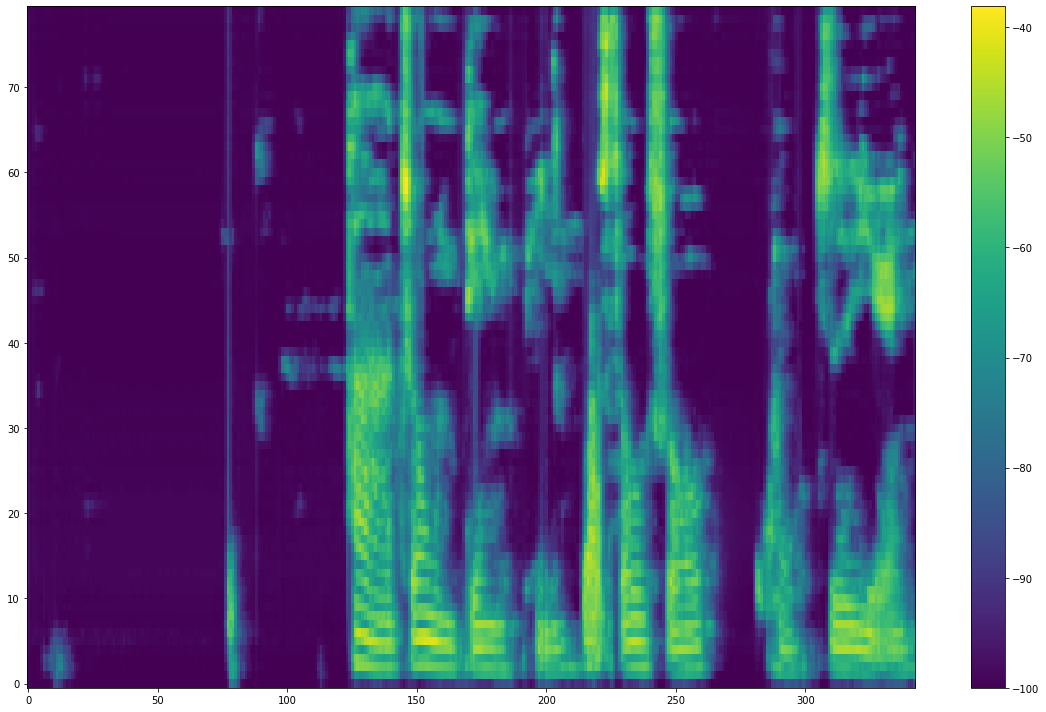

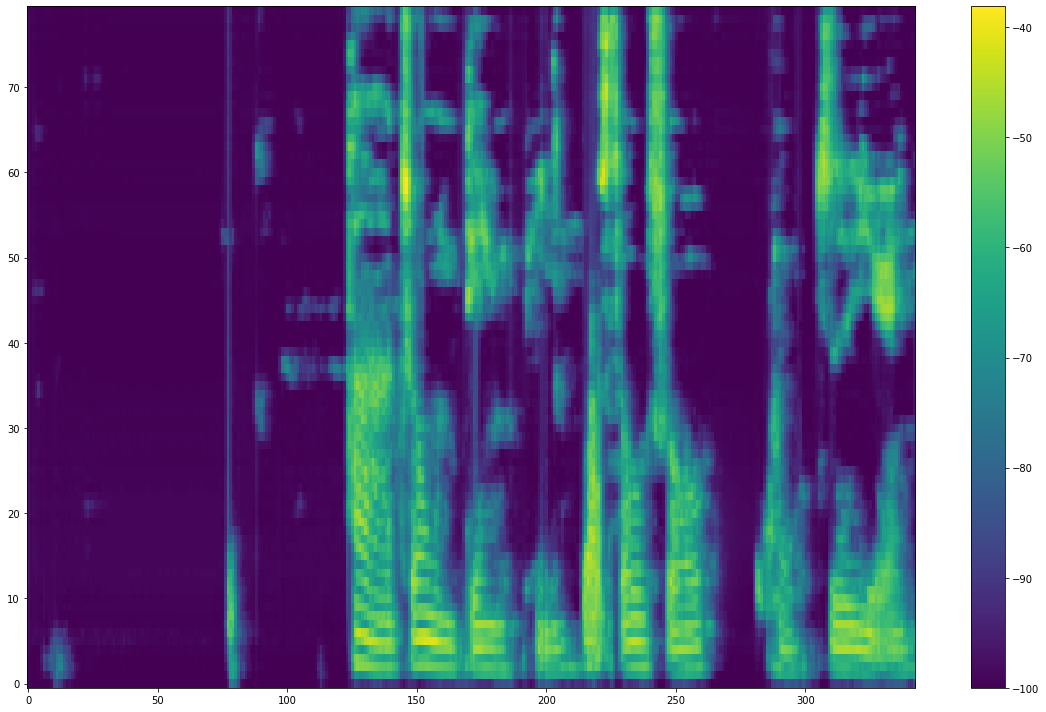

In [12]:
plot_spectrogram(a.T, ap)

In [13]:
b = np.load('/search/hadoop02/suanfa/wuzijun/Data/voice_data/Biaobei/Mels/mel/000522.npy')

In [15]:
b.shape

(80, 456)

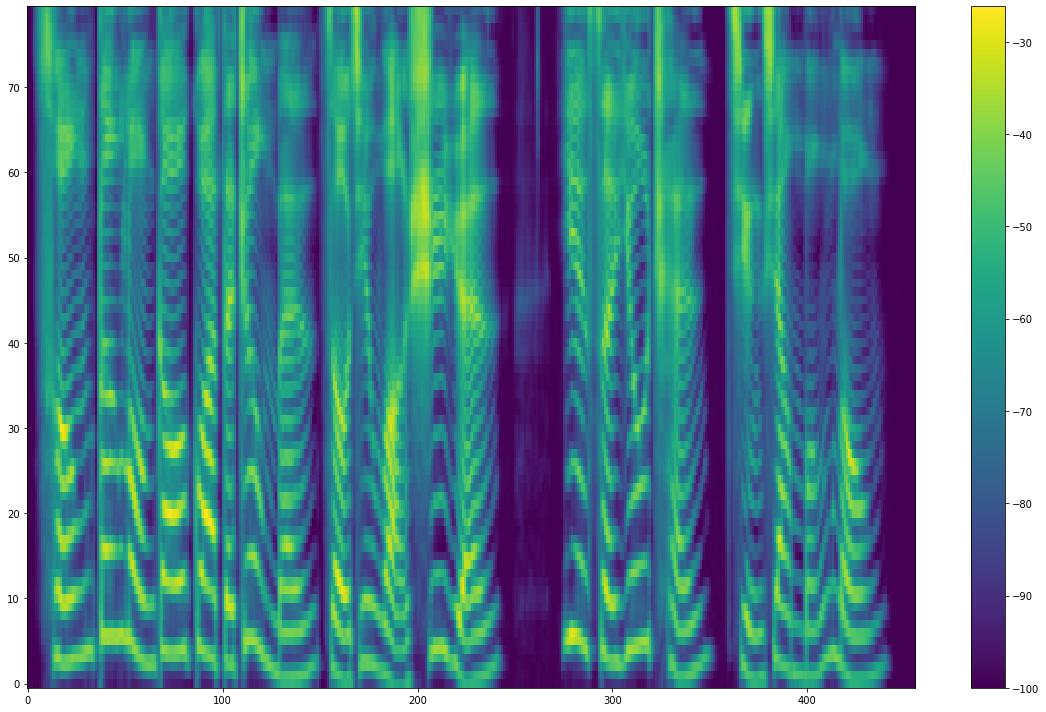

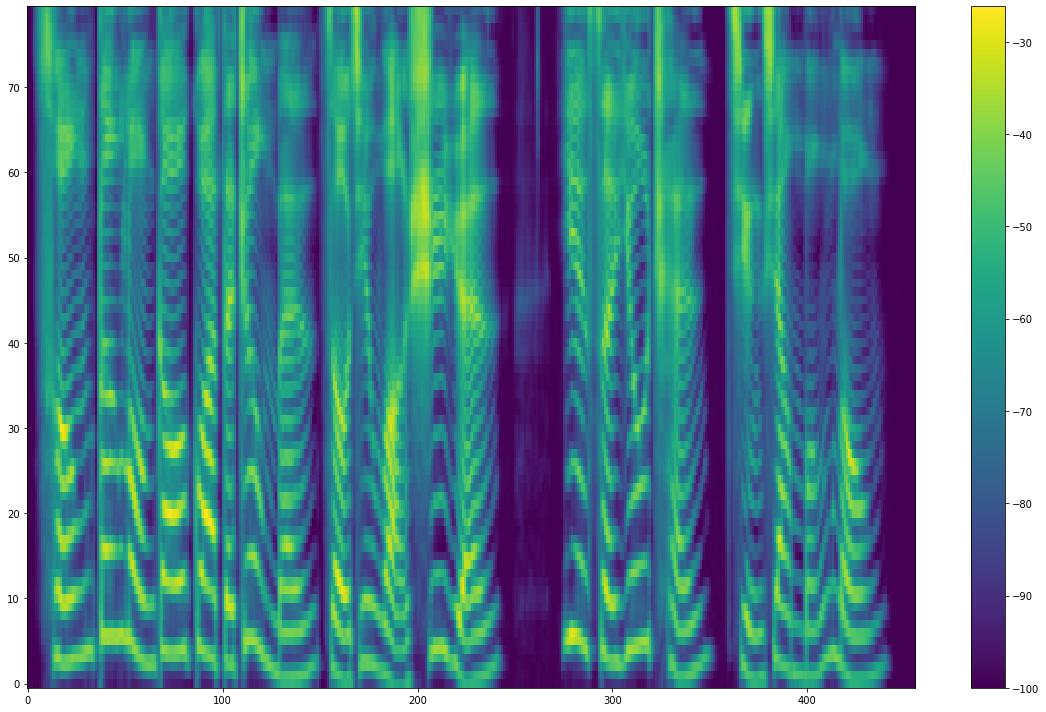

In [14]:
plot_spectrogram(b.T, ap)